# Задачи:

Определение вероятности подключения новой определенной услуги для каждой test-пары пользователь-услуга


Обзор датасета и загрузка данных:
* **data_train.csv**
В качестве исходных данных доступна информация об отклике абонентов на предложение подключения одной из услуг. Каждому пользователю может быть сделано несколько предложений в разное время, каждое из которых он может или принять, или отклонить. Обучение проходит на 831 653 размеченных записей.

* **data_test.csv**
Тестовый набор данных для итогового обучения модели. Содержит 71 231 записей.

* **features.csv**
Отдельный нормализованный анонимизированный набор признаков, характеризующий профиль потребления абонента (весом 21 GB). Эти данные привязаны к определенному времени, поскольку профиль абонента может меняться с течением времени. Содержит 4 512 528 записей. Даты совпадают как с трейном, так с в тестом

Описание данных:

* **id** - идентификатор абонента
* **vas_id** - подключаемая услуга
* **buy_time** - время покупки
* **target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу.

Данные train и test разбиты по периодам – на train доступно 4 месяцев, а на test отложен последующий месяц.

******

# Load Data and Modules

In [1]:
# Загрузка необходимых библиотек
import os
from pathlib import Path
import pickle
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import itertools
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, make_scorer, precision_recall_curve, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
warnings.filterwarnings('ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
pd.set_option('display.float_format', '{:.4f}'.format)

# FUNCTIONS

In [3]:
def n_value_control(data_f, col_name: str, group_list: list = [], func=1):
    """
    Обработка выбросов и NaN заначений
    :param df: DataFrame
    :param col_name: название столбца
    :param cor_method: способ обработки (1 - медиана, 2 - мода, 3 - среднее)
    :return: DataFrame group by condition 
    """
    if func == 1:
        ddf = data_f.groupby(group_list)[col_name].median()
    if func == 2:
        ddf = data_f.groupby(group_list)[col_name].agg(lambda x: mode(x)[0])
    if func == 3:
        ddf = data_f.groupby(group_list)[col_name].mean()
    ddf = pd.DataFrame(ddf)
    ddf.rename(columns={col_name: 'cor_col'}, inplace=True)
    return ddf

In [4]:
def get_classification_report(y_train_true, y_train_pred_proba, y_test_true, y_test_pred_proba, threshold=0.5):

    y_train_pred = y_train_pred_proba > threshold
    y_test_pred = y_test_pred_proba > threshold
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))


def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    f1_macro = f1_score(y_test_pred, y_test, average='macro')
    print("f1_macro = ", f1_macro)

    return f1_macro

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels, focus):
    preds_with_true_labels = np.array(
        list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold)), average='macro'))

    scores_table = pd.DataFrame({'f1': f1_scores,
                                 'precision': precisions,
                                 'recall': recalls,
                                 'probability': thresholds}).sort_values('f1', ascending=False).round(4)

    thresholds2 = []
    precisions2 = []
    recalls2 = []
    f1_scores2 = []

    for threshold2 in np.linspace(focus-0.015, focus+0.015, 15):
        thresholds2.append(threshold2)
        precisions2.append(precision_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2))))
        recalls2.append(recall_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2))))
        f1_scores2.append(f1_score(y_true_labels, list(
            map(int, y_predicted_probs > threshold2)), average='macro'))

    scores_table2 = pd.DataFrame({'f1': f1_scores2,
                                  'precision': precisions2,
                                  'recall': recalls2,
                                  'probability': thresholds2}).sort_values('f1', ascending=False).round(3)
    maxf1_proba = scores_table2.iloc[0, 3]

    figure = plt.figure(figsize=(15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.plot((maxf1_proba, maxf1_proba), (0, 1), 'g--')
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))
    plt1.table(cellText=scores_table.values,
               colLabels=scores_table.columns,
               colLoc='center', cellLoc='center', loc='bottom', bbox=[0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0],
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0],
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))
    plt2.table(cellText=scores_table2.values,
               colLabels=scores_table2.columns,
               colLoc='center', cellLoc='center', loc='bottom', bbox=[0, -1.3, 1, 1])
    plt.savefig('proba_calibration.png')
    plt.show()
    return maxf1_proba

In [6]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    f1 = make_scorer(f1_score, average='macro')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y,
                                                            cv=cv,
                                                            scoring=f1,
                                                            train_sizes=train_sizes,
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15, 8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame(
        {'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values(
        'importance', ascending=False)

    plt.figure(figsize=(10, len(feature_importances) * 0.3))

    sns.barplot(feature_importances['importance'],
                feature_importances['feature'])

    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()

    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(
        100 * (start_mem - end_mem) / start_mem))

    return df

In [9]:
def train_test_cat_compare(train_df, test_df, cat_list):
    dif_train_list = []
    dif_train_count = []
    colname_train_list = []
    dif_test_list = []
    dif_test_count = []
    colname_test_list = []
    for i in cat_list:
        train_cat_el = set(train_df[i].unique().tolist())
        test_cat_el = set(test_df[i].unique().tolist())
        dif_cat_train = test_cat_el - train_cat_el
        dif_cat_test = train_cat_el - test_cat_el
        if dif_cat_train != {}:
            for el in dif_cat_train:
                colname_train_list.append(i)
                dif_train_list.append(el)
                dif_train_count.append(test_df[test_df[i] == el][i].count())
        if dif_cat_test != {}:
            for el in dif_cat_test:
                colname_test_list.append(i)
                dif_test_list.append(el)
                dif_test_count.append(train_df[train_df[i] == el][i].count())

    dif_dict_test = {'Column_name': colname_train_list,
                     'Test_dif_category': dif_train_list, 'Line sum': dif_train_count}
    dif_dict_train = {'Column_name': colname_test_list,
                      'Test_dif_category': dif_test_list, 'Line sum': dif_test_count}

    if colname_train_list != []:
        print('\nКатегории присутвующие в test, но отсутсвующие в train ')
        dif_cat_test = pd.DataFrame(data=dif_dict_test)
        display(dif_cat_test)
        print('\n')

    if colname_test_list != []:
        print('\nКатегории присутвующие в train, но отсутсвующие в test ')
        dif_cat_train = pd.DataFrame(data=dif_dict_train)
        display(dif_cat_train)

    if (colname_test_list != []) & (colname_train_list != []):
        print('NO difference in train and test list of unique categorical elements')

In [10]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek',
                      'smote'], 'Неверный метод сэмплирования'

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(
        target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(
                target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(
            df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)

    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(
            df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Визуализация confusion matrix.
    Дополнительно возможно использование нормализаци, выставив значение `normalize=True`.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    font = {'size': 15}

    plt.rc('font', **font)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid()
    plt.savefig("confusion_matrix.png")
    
    plt.show()

# Load data, memory control

In [12]:
df_train = reduce_mem_usage(pd.read_csv('data/data_train.csv'))
X = df_train.drop(columns='target')
y = df_train['target']
df_test = reduce_mem_usage(pd.read_csv('data/data_test.csv'))

Memory usage of dataframe is 31.73 MB
Memory usage after optimization is: 15.86 MB
Decreased by 50.0%
Memory usage of dataframe is 2.17 MB
Memory usage after optimization is: 1.09 MB
Decreased by 50.0%


In [13]:
df_features = reduce_mem_usage(pd.read_csv('data/features.csv', sep='\t'))

Memory usage of dataframe is 8813.53 MB
Memory usage after optimization is: 4406.77 MB
Decreased by 50.0%


In [14]:
display(df_train.head(2), df_test.head(2), df_features.head(2))

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0000,1537131600,0.0000
1,1,1454121,4.0000,1531688400,0.0000


,Unnamed: 0,id,vas_id,buy_time
0,0,3130519,2.0000,1548018000
1,1,2000860,4.0000,1548018000


,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,0,2013026,1531688400,18.9100,46.9809,4.9692,-1.3868,3.7918,-14.0118,-16.0862,...,-977.3738,-613.7708,-25.9963,-37.6304,-301.7477,-25.8329,-0.6944,-12.1759,-0.4561,0.0000
1,1,2014722,1539550800,36.6900,152.4009,448.0692,563.8332,463.8418,568.9982,-16.0862,...,-891.3738,-544.7708,-20.9963,48.3696,80.2523,-13.8329,-0.6944,-1.1759,-0.4561,0.0000


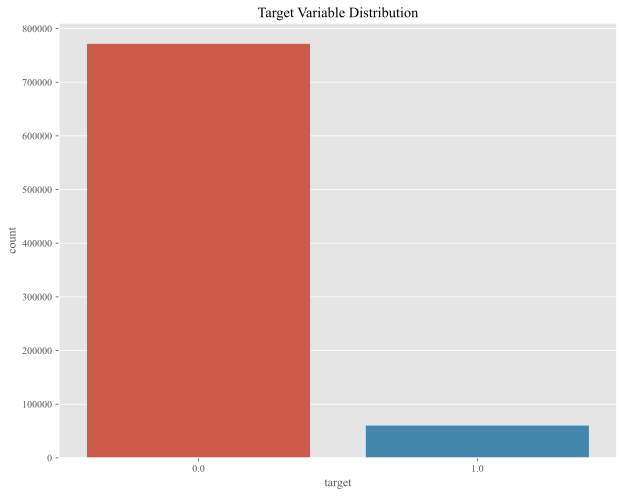

In [15]:
plt.figure(figsize=(10, 8))
plt.title('Target Variable Distribution')
sns.countplot(x='target', data=df_train)
plt.savefig("Target Variable Distribution.png")

# DATA Preprocessing

In [16]:
class Preprocessing(BaseEstimator, TransformerMixin):

    def __init__(self, df_features):
        self.X = None
        self.df_features = df_features
        self.categorical = ['131', '133', '15', '155', '193', '196',
                            '216', '218', '220', '23', '24', '28', '29', '30', '95']

        self.feature_selection_list = ['vas_id', 'buy_time', '226', '1', '191', '207', '247', '164', '241', '193_mean',
                                       '144', '240', '3', '61', '145', '238', '114', '52', '128', '58', '53', '146', '229',
                                       '172', '115', '230', '64', '188', '243', '239', '222', '47', '127', '37', '39', '63',
                                       '5', '49', '210', '126', '43', '0', '224', '60', '248', '236', '187', '244', '211',
                                       '62', '130', '246', '234', '40', '143', '208', '111', '213', '20', '55']

        self.cat_dict = {}

    def fit(self, X, y):
        self.X = X
        self.y = y

        return self

    def transform(self, X):

        self.df_features.drop_duplicates('id', keep='first', inplace=True)
        if 'Unnamed: 0' in self.df_features:
            self.df_features.drop(columns='Unnamed: 0', inplace=True)

        if 'Unnamed: 0' in X.columns:
            X.drop(columns='Unnamed: 0', inplace=True)
        X = pd.merge(X, self.df_features, how='left', on='id')

        X['merge_flag'] = 0
        X.loc[X['buy_time_x'] ==
              X['buy_time_y'], 'merge_flag'] = 1
        X.rename(columns={'buy_time_x': 'buy_time'}, inplace=True)
        X.drop(columns='buy_time_y', inplace=True)

        # drop const col =================================================

        X.drop(columns=['139', '203', '75', '81', '85'],
               inplace=True)

        # cat-> target_mean ==========================================

        if self.cat_dict == {}:
            X = pd.concat([X, self.y], axis=1)
            for col in self.categorical:
                temp = X.groupby(by=col)['target'].mean()
                temp.name = f'{col}_mean'
                self.cat_dict[col] = temp

        for dcol in self.cat_dict:
            X = pd.merge(X, self.cat_dict[dcol], how='left', on=dcol)
            X.drop(columns=dcol, inplace=True)

        if 'target' in X.columns:
            X.drop(columns='target', inplace=True)

        X['vas_id'] = X['vas_id'].astype('int8')
        X['buy_time'] = X['buy_time'].astype('int32')
        X.set_index('id', inplace=True)

        return X[self.feature_selection_list]

In [17]:
preprocessor = Preprocessing(df_features)
preprocessor.fit(X, y)
data = preprocessor.transform(X)

== == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == == ====== 

# Modeling

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=13)

In [19]:
DISBALANCE = df_train['target'].value_counts(
)[0] / df_train['target'].value_counts()[1]

**********************************

In [20]:
model_xgb = XGBClassifier(random_state=13,
                          n_estimators=450,
                          max_depth=7,
                          learning_rate=0.004,
                          reg_lambda=0.85,
                          reg_alpha=0.8,
                          scale_pos_weight=DISBALANCE,
                          eval_metric='logloss',
                          importance_type='weight')
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='weight',
              interaction_constraints='', learning_rate=0.004, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=450, n_jobs=16,
              num_parallel_tree=1, random_state=13, reg_alpha=0.8,
              reg_lambda=0.85, scale_pos_weight=12.818047386435383, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [21]:
y_train_pred_proba = model_xgb.predict_proba(X_train)[:, 1]
y_test_pred_proba = model_xgb.predict_proba(X_test)[:, 1]

In [22]:
model_xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='weight',
              interaction_constraints='', learning_rate=0.004, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=450, n_jobs=16,
              num_parallel_tree=1, random_state=13, reg_alpha=0.8,
              reg_lambda=0.85, scale_pos_weight=12.818047386435383, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
get_classification_report(y_train, y_train_pred_proba,
                          y_test, y_test_pred_proba)

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    578600
         1.0       0.35      0.91      0.51     45139

    accuracy                           0.87    623739
   macro avg       0.67      0.89      0.72    623739
weighted avg       0.95      0.87      0.90    623739

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    192867
         1.0       0.35      0.91      0.51     15047

    accuracy                           0.87    207914
   macro avg       0.67      0.89      0.72    207914
weighted avg       0.95      0.87      0.90    207914



# Probabilities threshold calibration

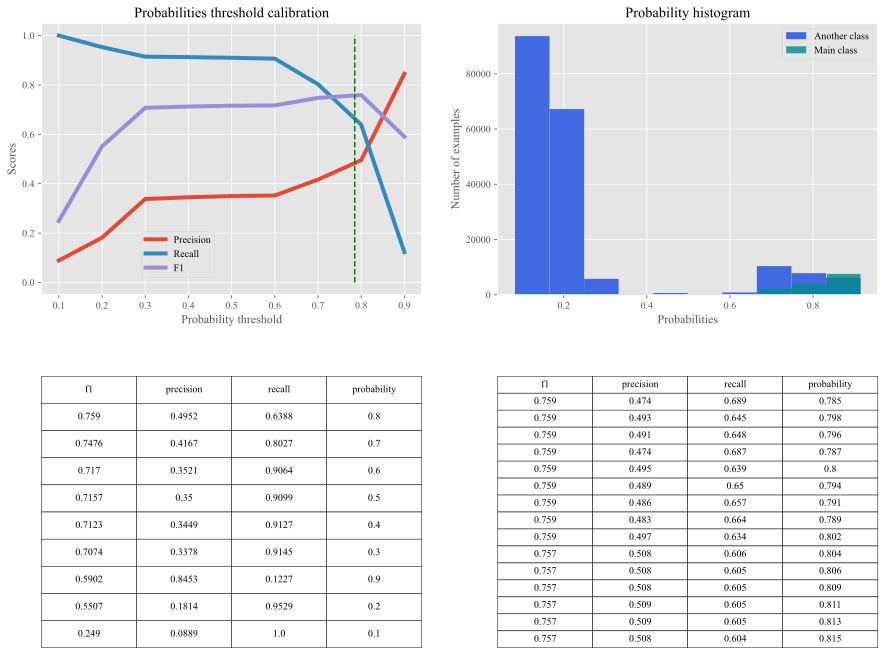

0.785

In [24]:
show_proba_calibration_plots(y_test_pred_proba, y_test, focus=0.8)

In [25]:
THRESHOLD = 0.8

In [26]:
get_classification_report(y_train, y_train_pred_proba,
                          y_test, y_test_pred_proba, threshold=THRESHOLD)

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96    578600
         1.0       0.50      0.64      0.56     45139

    accuracy                           0.93    623739
   macro avg       0.73      0.80      0.76    623739
weighted avg       0.94      0.93      0.93    623739

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96    192867
         1.0       0.50      0.64      0.56     15047

    accuracy                           0.93    207914
   macro avg       0.73      0.79      0.76    207914
weighted avg       0.94      0.93      0.93    207914



Confusion matrix, without normalization


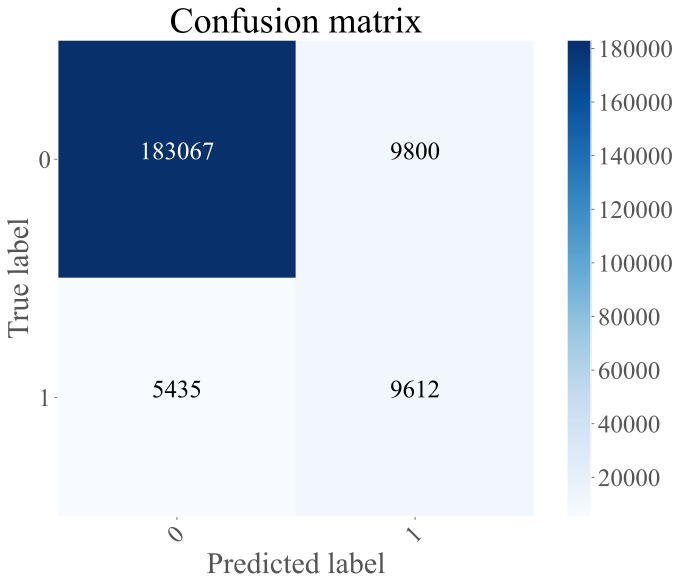

In [42]:
y_pred_test_final = y_test_pred_proba > THRESHOLD
cm = confusion_matrix(y_test, y_pred_test_final)
plot_confusion_matrix(cm, classes=['0', '1'])

In [28]:
print('*'*100)
print(
    f' f1_macro после выбора порога вероятности: {round(f1_score(y_test, y_pred_test_final, average="macro"),2)}')

****************************************************************************************************
 f1_macro после выбора порога вероятности: 0.76


=====================================================================================================

# PIPELINE. SAVE MODEL

In [29]:
xgb_params = {
    "random_state": 13,
    "max_depth": 7,
    "n_estimators": 450,
    "learning_rate": 0.004,
    "reg_lambda": 0.85,
    "reg_alpha": 0.8,
    "eval_metric": "logloss",
    "scale_pos_weight": DISBALANCE,
}

In [30]:
# make pipeline
pipeline = Pipeline([
    ("preprocessor", Preprocessing(df_features)),
    ("classifier", XGBClassifier(**xgb_params))
])

In [31]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 Preprocessing(df_features=              id    buy_time        0         1         2         3         4  \
0        2013026  1531688400  18.9100   46.9809    4.9692   -1.3868    3.7918   
1        2014722  1539550800  36.6900  152.4009  448.0692  563.8332  463.8418   
2        2015199  1545598800 -67.0200  157.0509  -63.1808  178.1032  -68.5982   
3        2021765  1534107600   7.0100  150.2009   -6.9308  216.2132   76.6218   
4        2027465  1533502800 -90.4400  134.2209 -104.3808  153.6432 -109....
                               gamma=0, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.004,
                               max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=450,
                               n_jobs=16, num_parallel_tree=1, random_state=13,
     

In [32]:
if not os.path.exists(os.path.join(Path(os.getcwd()), "model")):
    os.mkdir(os.path.join(Path(os.getcwd()), "model"))
with open(os.path.join(Path(os.getcwd()), "model", "xgb_model_pipeline.pickle"), "wb") as f1:
    pickle.dump(pipeline, f1)
with open(os.path.join(Path(os.getcwd()), "model", "xgb_model.pickle"), "wb") as f2:
    pickle.dump(model_xgb, f2)

------------------------

In [33]:
# test
with open(os.path.join(Path(os.getcwd()), "model", "xgb_model_pipeline.pickle"), "rb") as f1:
    pipeline_ = pickle.load(f1)

In [34]:
predictions = pipeline_.predict_proba(df_test)

In [35]:
df_test['target'] = predictions[:, 1]
df_test.set_index('id', inplace=True)
display(df_test.head(3))
df_test.to_csv('prediction_test.csv')

,vas_id,buy_time,target
id,,,
3130519,2.0000,1548018000,0.0826
2000860,4.0000,1548018000,0.8045
1099444,2.0000,1546808400,0.0826


In [36]:
#!pip freeze > requirements.txt